# Homework 2

In [57]:
%pip install -U sklearn pandas imblearn matplotlib shap dalex nbformat


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Preprocessing

There are three binary features: `ever_married = Yes/No`, `Residence_type = Urban/Rural`, `gender = Male/Female`, therefore all of them are replaced with a boolean value.

`work_type` and `smoking_status` have more possible values, so they are one-hot encoding is used for them.

In [58]:
import pandas as pd
import functools

data = pd.read_csv("brain_stroke.csv")

data["ever_married"] = data["ever_married"] == "Yes"
data["urban"] = data["Residence_type"] == "Urban"
data = data.drop("Residence_type", axis=1)
data["male"] = data["gender"] == "Male"
data = data.drop("gender", axis=1)

def one_hot(data, column):
  return data.drop(column, axis=1).join(pd.get_dummies(data[column], prefix=column))

data = functools.reduce(one_hot, ["work_type", "smoking_status"], data)
data = data.rename(lambda x: x.lower(), axis=1)

data.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,urban,male,work_type_govt_job,work_type_private,work_type_self-employed,work_type_children,smoking_status_unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,True,228.69,36.6,1,True,True,0,1,0,0,0,1,0,0
1,80.0,0,1,True,105.92,32.5,1,False,True,0,1,0,0,0,0,1,0
2,49.0,0,0,True,171.23,34.4,1,True,False,0,1,0,0,0,0,0,1
3,79.0,1,0,True,174.12,24.0,1,False,False,0,0,1,0,0,0,1,0
4,81.0,0,0,True,186.21,29.0,1,True,True,0,1,0,0,0,1,0,0


# Train/test split

In [70]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.1, random_state=1)
train_X, train_y = train.drop("stroke", axis=1), train["stroke"]
test_X, test_y = test.drop("stroke", axis=1), test["stroke"]

# reset indexes
train_X, train_y = train_X.reset_index(drop=True), train_y.reset_index(drop=True)
test_X, test_y = test_X.reset_index(drop=True), test_y.reset_index(drop=True)

# normalization
mean, std = train_X.mean(), train_X.std()
train_X = (train_X - mean) / std
test_X = (test_X - mean) / std

# Metrics

We'll be measuring accuracy, precision, recall and f1 score.

In [71]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, RocCurveDisplay

def metrics(name, pred, gt):
  print(f"Results for {name}")
  print(" - accuracy: ", accuracy_score(gt, pred))
  print(" - precision: ", precision_score(gt, pred))
  print(" - recall: ", recall_score(gt, pred))
  print(" - f1 score: ", f1_score(gt, pred))

def draw_roc(name, scores, gt):
  print(f"ROC curve for {name}")
  fpr, tpr, _ = roc_curve(gt, scores)
  RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# Random forest

Similarly to previous, applied balanced class weight. Reduced max depth in order to prevent overfitting.

Results for Random Forest
 - accuracy:  0.779559118236473
 - precision:  0.152
 - recall:  0.8260869565217391
 - f1 score:  0.25675675675675674
ROC curve for Random Forest


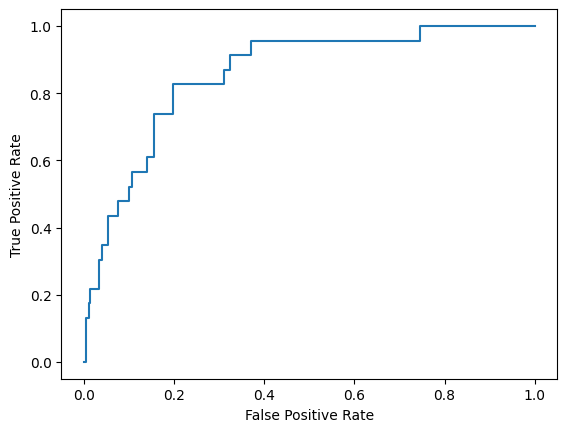

In [72]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight="balanced", max_depth=6).fit(train_X, train_y)

pred = rf_model.predict(test_X)
scores = rf_model.predict_proba(test_X)[:,1]

metrics("Random Forest", pred, test_y)
draw_roc("Random Forest", scores, test_y)

# Shapley analysis

## 2. Select two observations from the dataset and calculate the model's prediction.

In [73]:
import shap
import dalex

predict_proba = lambda x: rf_model.predict_proba(x)[:, 1]

sample_X = train_X.sample(n=2, replace=False, random_state=4)

def denormalize(data):
  return data * std + mean

print("Samples:")
denormalize(sample_X)

Samples:


,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,urban,male,work_type_govt_job,work_type_private,work_type_self-employed,work_type_children,smoking_status_unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
457,81.0,0.0,1.0,1.0,78.70,19.4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1016,50.0,0.0,0.0,1.0,57.93,27.6,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [74]:
print("Prediction:")
predict_proba(sample_X)

Prediction:


array([0.60734313, 0.32169711])

## 3. Next, for the same observations, calculate the decomposition of predictions, so-called variable attributions, using SHAP from two packages of choice, e.g. for Python: `dalex` and `shap`, for R: `DALEX` and `iml`.

In [75]:
explainer_shap = shap.TreeExplainer(rf_model)
explainer_dalex = dalex.Explainer(rf_model, train_X, train_y, verbose=False)

sample_explanations_shap = explainer_shap(train_X)
sample_explanations_shap1 = sample_explanations_shap[sample_X.index.values[0], :, 1]
sample_explanations_shap2 = sample_explanations_shap[sample_X.index.values[1], :, 1]
sample_explanations_dalex1 = explainer_dalex.predict_parts(sample_X.iloc[[0]], 'shap', N=500, random_state=1)
sample_explanations_dalex2 = explainer_dalex.predict_parts(sample_X.iloc[[1]], 'shap', N=500, random_state=1)

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



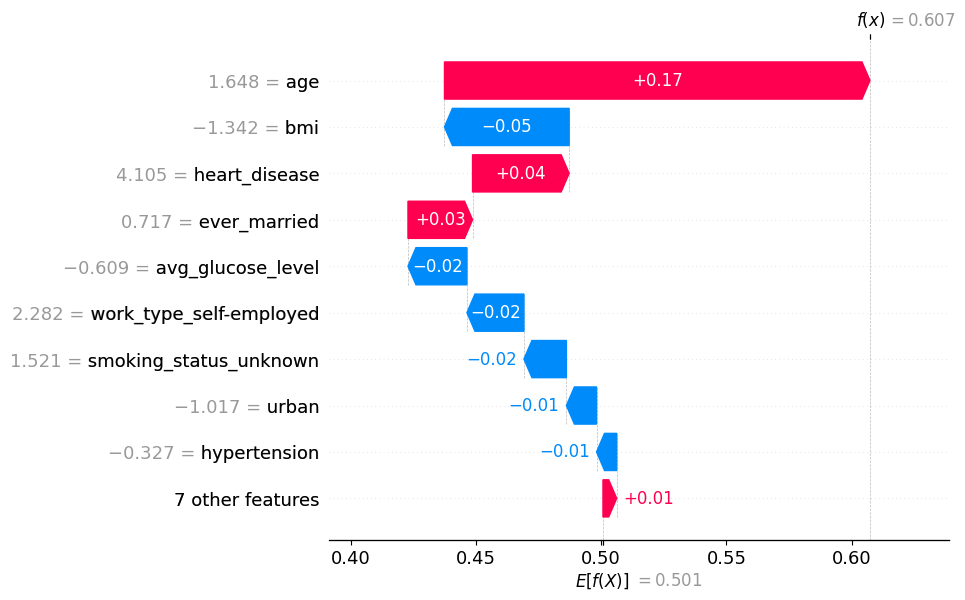

In [76]:
shap.waterfall_plot(sample_explanations_shap1)

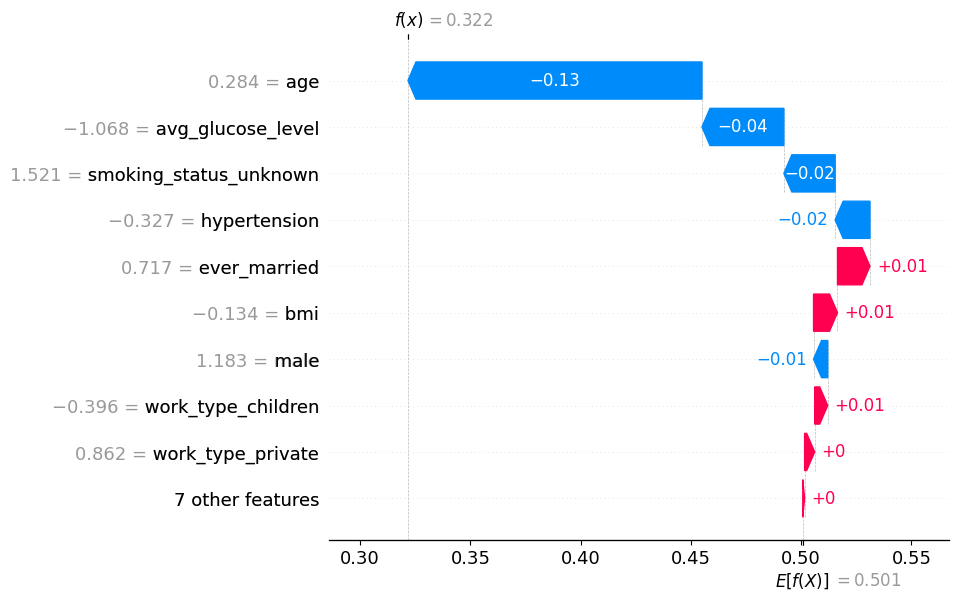

In [77]:
shap.waterfall_plot(sample_explanations_shap2)

In [78]:
sample_explanations_dalex1.plot()

In [79]:
sample_explanations_dalex2.plot()

## 4. Find any two observations in the dataset, such that they have different variables of the highest importance, e.g. age and gender have the highest (absolute) attribution for observation A, but race and class are more important for observation B.

In [80]:
import numpy as np

abs_values = np.abs(sample_explanations_shap[:, :, 1].values)
high1 = np.unravel_index(np.argmax(abs_values), abs_values.shape)

high1_column = abs_values[:, high1[1]]

# subtract the high column in order to find the example with the largest difference
abs_values -= high1_column.reshape((-1, 1))
high2 = np.unravel_index(np.argmax(abs_values), abs_values.shape)
high2

sample1, feature1 = high1
sample2, feature2 = high2

In [81]:
denormalize(train_X.iloc[[sample1]])

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,urban,male,work_type_govt_job,work_type_private,work_type_self-employed,work_type_children,smoking_status_unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
3698,29.0,0.0,0.0,1.0,185.27,31.3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


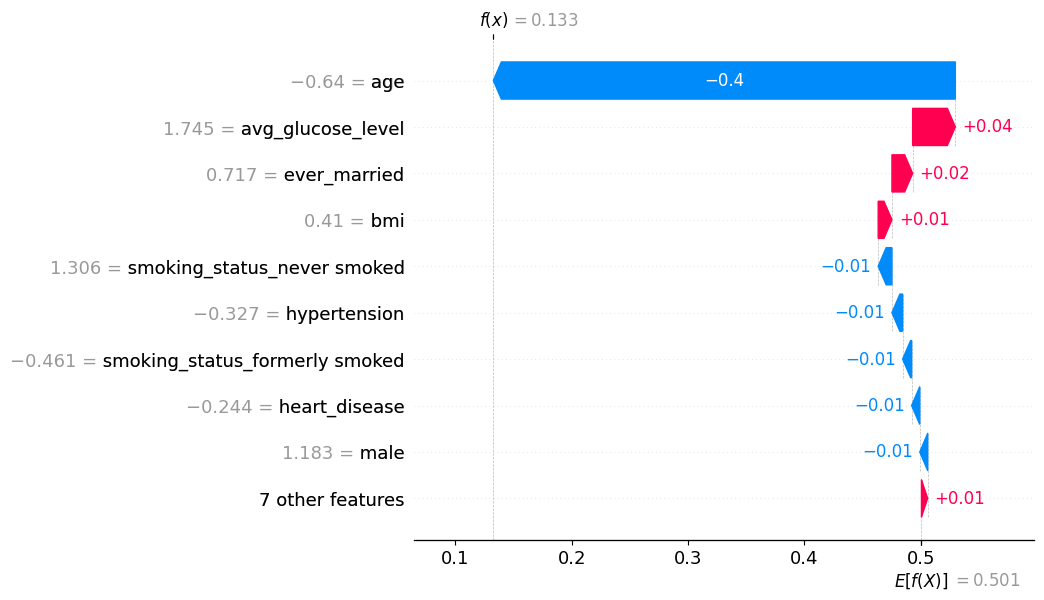

In [82]:
sample1_explanation = sample_explanations_shap[sample1, :, 1]
shap.waterfall_plot(sample1_explanation)

In [83]:
denormalize(train_X.iloc[[sample2]])

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,urban,male,work_type_govt_job,work_type_private,work_type_self-employed,work_type_children,smoking_status_unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
728,70.0,1.0,0.0,1.0,214.77,15.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


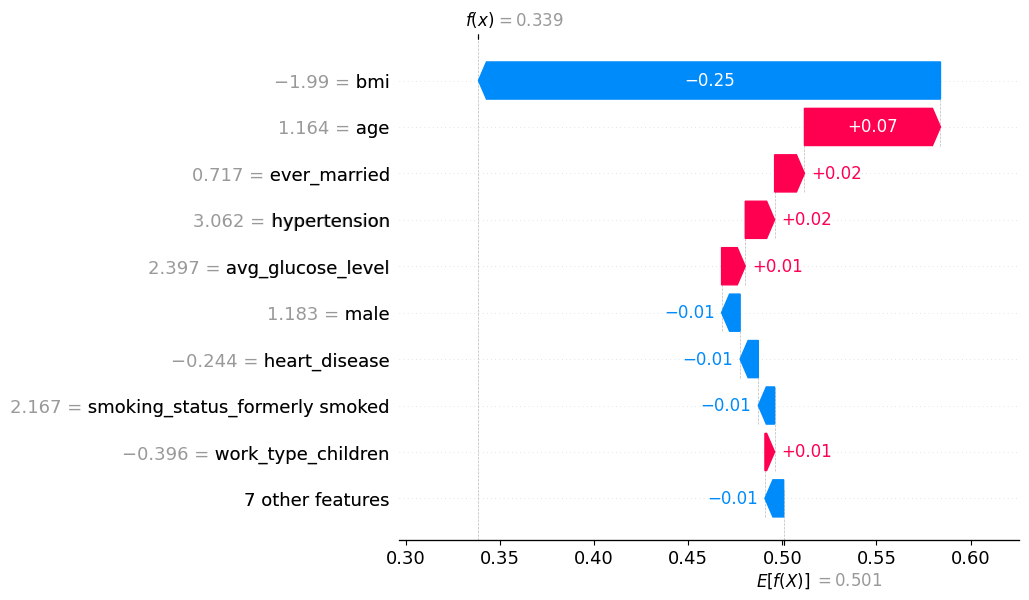

In [84]:
sample2_explanation = sample_explanations_shap[sample2, :, 1]
shap.waterfall_plot(sample2_explanation)

In the first example we can see that a relatively young age contributes greatly to negative diagnosis. The prediction in the second example suggests that a very low bmi is the predominant factor in determining a negative diagnosis.

## 5. (If possible) Select one variable X and find two observations in the dataset such that for one observation, X has a positive attribution, and for the other observation, X has a negative attribution.

In [86]:
feature = 0 # age
values = sample_explanations_shap[:, feature, 1].values

sample1 = np.argmax(values)
sample2 = np.argmin(values)

In [87]:
denormalize(train_X.iloc[[sample1]])

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,urban,male,work_type_govt_job,work_type_private,work_type_self-employed,work_type_children,smoking_status_unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2312,79.0,0.0,0.0,0.0,88.92,22.9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


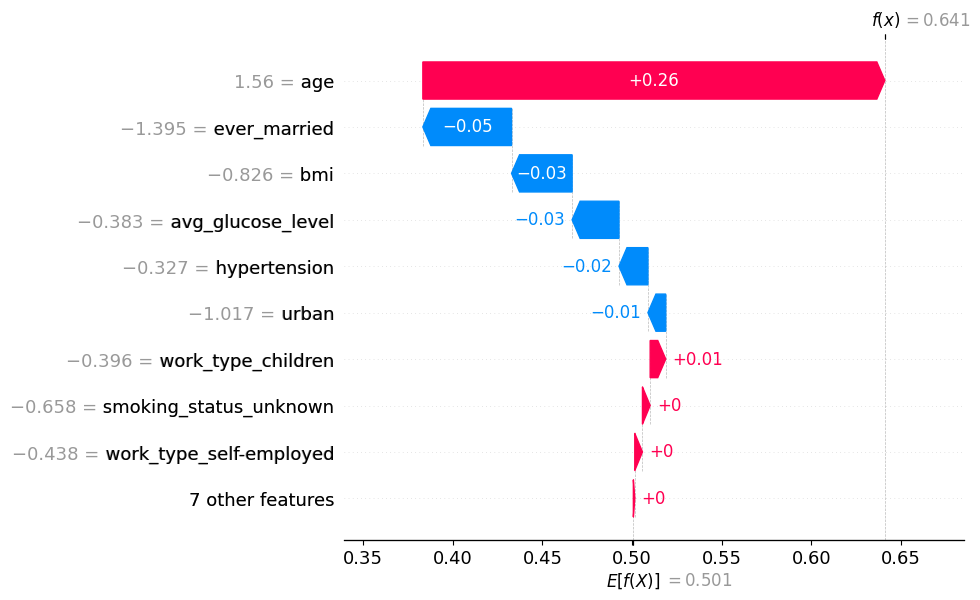

In [88]:
sample1_explanation = sample_explanations_shap[sample1, :, 1]
shap.waterfall_plot(sample1_explanation)

In [89]:
denormalize(train_X.iloc[[sample2]])

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,urban,male,work_type_govt_job,work_type_private,work_type_self-employed,work_type_children,smoking_status_unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
3698,29.0,0.0,0.0,1.0,185.27,31.3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


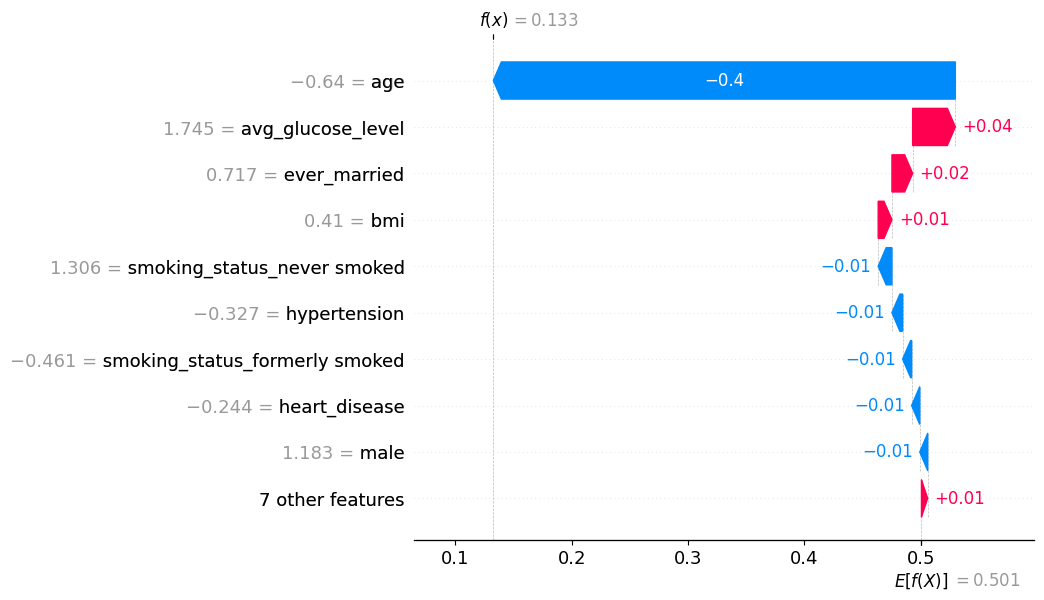

In [91]:
sample2_explanation = sample_explanations_shap[sample2, :, 1]
shap.waterfall_plot(sample2_explanation)

We can see that old age (first sample) contributes greatly to a positive prediction, while a relatively young age (second sample) contributes negatively.

## 6. (How) Do the results differ across the two packages selected in point (3)?

In [93]:

sample_explanations_dalex1 = explainer_dalex.predict_parts(train_X.iloc[[sample1]], 'shap', N=500, random_state=1)
sample_explanations_dalex2 = explainer_dalex.predict_parts(train_X.iloc[[sample2]], 'shap', N=500, random_state=1)

In [94]:
sample_explanations_dalex1.plot()

In [95]:
sample_explanations_dalex2.plot()

They roughly agree on these samples: both packages point out `age` as the most relevant feature although they differ in terms of exact numbers. There's some discrepency among less important features, for instance in the first sample `bmi` is considered to be the third most contributing factor for `shap` while `dalex` doesn't recognise it even among the top 9 most relevant features. Notably, though, they agree on all of the most important features' signs (ie. whether they contribute positively or negatively towards the prediction).

## 7. (Using one explanation package of choice) Train another model of any class: neural network, linear model, decision tree etc. and find an observation for which SHAP attributions are different between this model and the one trained in point (1).

# Logistic regression

Applied balanced class weight due to class imbalance.

Results for Logistic Regression
 - accuracy:  0.7595190380761523
 - precision:  0.1510791366906475
 - recall:  0.9130434782608695
 - f1 score:  0.25925925925925924
ROC curve for Logistic Regression


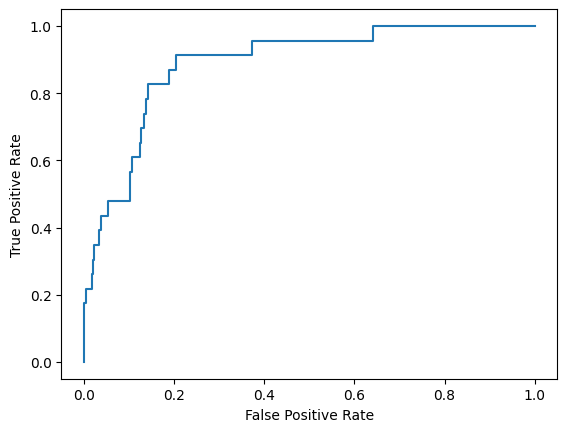

In [96]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

lr_model = LogisticRegression(max_iter=1000, class_weight="balanced").fit(train_X, train_y)

pred = lr_model.predict(test_X)
scores = lr_model.decision_function(test_X)

metrics("Logistic Regression", pred, test_y)
draw_roc("Logistic Regression", scores, test_y)

In [103]:
explainer_lr = shap.Explainer(lambda x: lr_model.predict_proba(x)[:, 1], train_X)
explanations_lr = explainer_lr(train_X)

Permutation explainer: 4483it [02:33, 27.29it/s]                          


IndexError: too many indices for array

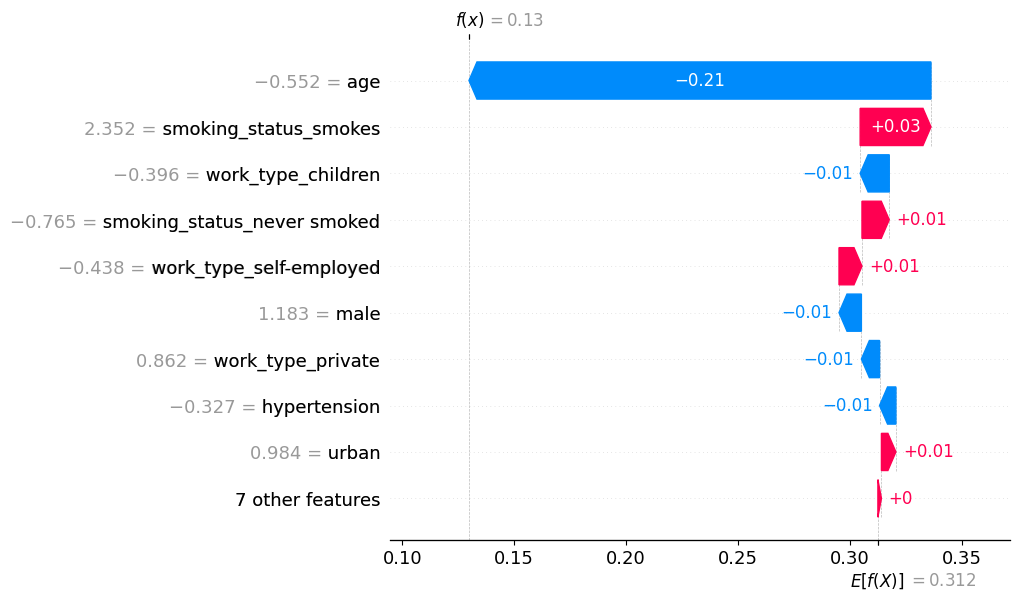

In [104]:
shap.waterfall_plot(explanations_lr[0, :])

In [105]:
rf_shap = sample_explanations_shap[:, :, 1].values
lr_shap = explanations_lr[:, :].values

diff = rf_shap - lr_shap
diff_magnitude = np.linalg.norm(diff, axis=1)
sample = np.argmax(diff_magnitude)


In [106]:
denormalize(train_X.iloc[[sample]])

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,urban,male,work_type_govt_job,work_type_private,work_type_self-employed,work_type_children,smoking_status_unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
4236,82.0,0.0,1.0,1.0,211.88,28.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


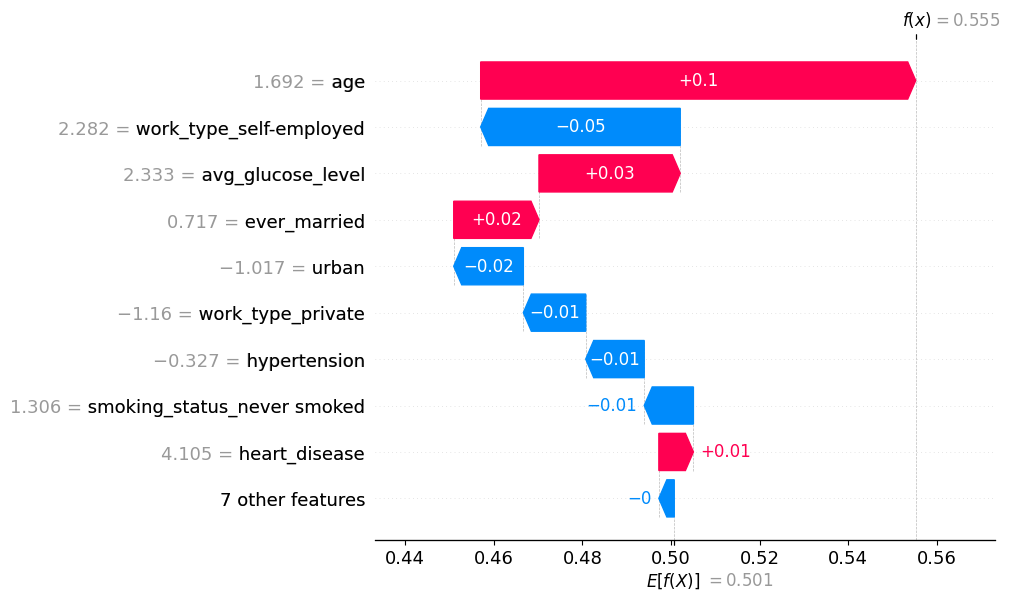

In [107]:
shap.waterfall_plot(sample_explanations_shap[sample, :, 1])

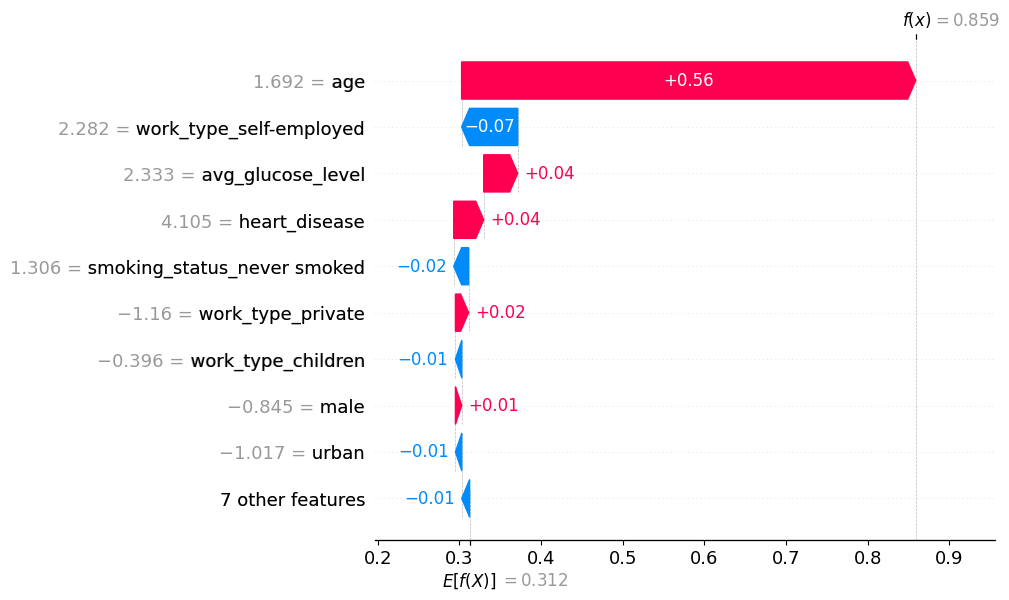

In [108]:
shap.waterfall_plot(explanations_lr[sample, :])

In [109]:
train_y[[sample]]

4236    0
Name: stroke, dtype: int64

Looking at the biggest-difference example (in terms of L2 norm) it differs mostly in relevance of age. Random trees consider age of this patient as mostly irrelevant, while logistic regression considers it to be very important. This results in the patient being (incorrectly) diagnosed with a brain stroke. While analysing previous examples, we could clearly see correlation of old age with brain stroke, so this is not surprising - logistic regression is forced to apply scores linearly and makes a reasonable decision given this constraint, while random trees are not limited this way.